In [6]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
print("package loaded")

package loaded


In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

^C


In [15]:
df = pd.read_csv("/kaggle/input/loan-status/Loan_status.csv",low_memory=False)

In [16]:
## Split Dataset
from sklearn.model_selection import train_test_split

# Step 1: Split off untouched data (10%)
df_train_val, df_untouched = train_test_split(df, test_size=0.10, random_state=42)
df_train_val = df_train_val.copy()  # Avoid SettingWithCopyWarning
df_untouched = df_untouched.copy()
df_untouched["set_flag"] = 0  # Mark untouched

# Step 2: Split remaining into train (50%), validation (20%), and test (20%)
df_train, df_temp = train_test_split(df_train_val, test_size=0.40, random_state=42)
df_train = df_train.copy()
df_temp = df_temp.copy()
df_train["set_flag"] = 1  # Mark train

df_val, df_test = train_test_split(df_temp, test_size=0.50, random_state=42)
df_val = df_val.copy()
df_test = df_test.copy()
df_val["set_flag"] = 2  # Mark validation
df_test["set_flag"] = 3  # Mark test

# Combine all subsets back into one dataframe
df_final = pd.concat([df_train, df_val, df_test, df_untouched], ignore_index=True)

# Save as Parquet for efficient storage
df_final.to_parquet("dataset_with_flags.parquet", index=False)

# Check dataset sizes
print(f"Training Set: {len(df_train)} rows ({len(df_train)/len(df)*100:.1f}%)")
print(f"Validation Set: {len(df_val)} rows ({len(df_val)/len(df)*100:.1f}%)")
print(f"Test Set: {len(df_test)} rows ({len(df_test)/len(df)*100:.1f}%)")
print(f"Untouched Set: {len(df_untouched)} rows ({len(df_untouched)/len(df)*100:.1f}%)")

print("Data saved with set_flag column.")

Training Set: 1579765 rows (54.0%)
Validation Set: 526589 rows (18.0%)
Test Set: 526589 rows (18.0%)
Untouched Set: 292550 rows (10.0%)
Data saved with set_flag column.


In [17]:
## Drop features with > 50% missing values
missing_percent = (df_train.isna().sum() / len(df_train))* 100
cols_to_drop = missing_percent[missing_percent > 50].index
print(cols_to_drop)
df_train_dropped = df_train.drop(columns=cols_to_drop)

Index(['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d',
       'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint',
       'verification_status_joint', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount'],
      dtype='object')


In [19]:
# create categories for loan status
loss = ['Charged Off', 'Does not meet the credit policy. Status:Charged Off', 'Default']
good = ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Charged Off', 'Issued']
df_train_dropped['loan_category'] = df_train_dropped['loan_status'].apply(lambda x: 'Loss' if x in loss else ('Good' if x in good else 'Other'))

In [20]:
# filter only good and loss
df_train_dropped = df_train_dropped[df_train_dropped['loan_category'].isin(['Loss', 'Good'])]
# convert to numerical encoding
df_train_dropped['loan_cat_numerical'] = df_train_dropped['loan_category'].map({'Loss': 0, 'Good': 1})
df_train_dropped['loan_cat_numerical'].value_counts()

loan_cat_numerical
1    1366857
0     196126
Name: count, dtype: int64

In [21]:
# Identify columns with string (object) content
string_columns = df_train_dropped.select_dtypes(include=['object']).columns.tolist()

# Display the list of column names containing string content
string_columns

['id',
 'term',
 'int_rate',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'revol_util',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'hardship_flag',
 'debt_settlement_flag',
 'loan_category']

In [23]:
## Convert home_ownership into numerical
df_train_dropped['home_ownership'].unique()

df_train_dropped['home_ownership'].isnull().sum()

# perform one-hot encoding 
df_train_dropped = pd.get_dummies(df_train_dropped, columns=['home_ownership'], drop_first=False)

# convert the true/false into 1/0
home_ownership_cols = [col for col in df_train_dropped.columns if col.startswith('home_ownership_')]
df_train_dropped[home_ownership_cols] = df_train_dropped[home_ownership_cols].astype(int)
df_train_dropped.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,set_flag,loan_category,loan_cat_numerical,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
1156958,73975,151456058,35000.0,35000.0,35000.0,36 months,16.40%,1237.42,C,C4,VP Business Planning & Analysis,10+ years,124000.0,Verified,May-2019,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,627xx,IL,30.15,0.0,Nov-1997,690.0,694.0,1.0,17.0,0.0,50995.0,89%,33.0,w,26055.42,26055.42,13547.840000,13547.84,8944.58,4603.26,0.00,0.0,0.0,Jun-2020,0.00,May-2020,684.0,680.0,0.0,1.0,Individual,0.0,0.0,203897.0,0.0,2.0,1.0,1.0,12.0,41391.0,68.0,1.0,1.0,12060.0,89.0,57490.0,1.0,6.0,1.0,2.0,11993.0,4256.0,96.0,0.0,0.0,157.0,258.0,10.0,10.0,1.0,10.0,6.0,0.0,8.0,14.0,10.0,10.0,12.0,14.0,20.0,15.0,17.0,NaN,0.0,0.0,2.0,100.0,100.0,0.0,0.0,246055.0,104457.0,34050.0,61019.0,Y,N,1,Good,1,0,1,0,0,0,0
1096736,13753,152802725,15000.0,15000.0,15000.0,60 months,10.33%,321.15,B,B1,SALES,10+ years,110250.0,Not Verified,Jun-2019,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,601xx,IL,13.54,1.0,Oct-1985,710.0,714.0,2.0,15.0,0.0,11884.0,20.3%,37.0,f,0.00,0.00,1292.050000,1292.05,778.08,497.91,16.06,0.0,0.0,Nov-2019,337.21,Oct-2019,694.0,690.0,0.0,1.0,Joint App,0.0,0.0,170230.0,2.0,1.0,0.0,1.0,14.0,18303.0,73.0,2.0,2.0,4523.0,36.0,58600.0,1.0,0.0,2.0,4.0,11349.0,27627.0,29.7,0.0,0.0,113.0,244.0,6.0,6.0,4.0,58.0,2.0,1.0,7.0,8.0,7.0,14.0,4.0,13.0,28.0,8.0,15.0,0.0,0.0,0.0,2.0,80.6,0.0,0.0,0.0,226151.0,30187.0,39300.0,25101.0,N,N,1,Loss,0,0,1,0,0,0,0
2421009,132153,68564941,12000.0,12000.0,12000.0,60 months,11.99%,266.88,C,C1,Child Support Specialist,2 years,45000.0,Verified,Jan-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,543xx,WI,20.99,1.0,Sep-2003,680.0,684.0,1.0,17.0,1.0,8980.0,28%,25.0,w,0.00,0.00,12991.860000,12991.86,12000.00,991.86,0.00,0.0,0.0,Sep-2016,11131.69,May-2020,699.0,695.0,0.0,1.0,Individual,0.0,8.0,98679.0,2.0,4.0,0.0,1.0,11.0,18849.0,82.0,2.0,5.0,6199.0,28.0,32350.0,0.0,0.0,2.0,6.0,5804.0,3079.0,38.0,0.0,0.0,147.0,146.0,2.0,2.0,1.0,5.0,5.0,0.0,7.0,12.0,9.0,9.0,8.0,12.0,16.0,4.0,17.0,NaN,0.0,0.0,2.0,96.0,28.6,1.0,0.0,131531.0,27829.0,21550.0,22931.0,N,N,1,Good,1,0,1,0,0,0,0
1957494,89733,63216388,10500.0,10500.0,10500.0,36 months,5.32%,316.21,A,A1,Recruiter II,1 year,58000.0,Not Verified,Oct-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Cre

In [24]:
## convert verification_status
df_train_dropped['verification_status'].unique()
df_train_dropped['verification_status'].isnull().sum()

# one-hot encoding 
df_train_dropped = pd.get_dummies(df_train_dropped, columns=['verification_status'], drop_first=False)

# convert true/false to 1/0
verification_status_cols = [col for col in df_train_dropped.columns if col.startswith('verification_status_')]
df_train_dropped[verification_status_cols] = df_train_dropped[verification_status_cols].astype(int)
df_train_dropped.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,annual_inc,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,set_flag,loan_category,loan_cat_numerical,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
1156958,73975,151456058,35000.0,35000.0,35000.0,36 months,16.40%,1237.42,C,C4,VP Business Planning & Analysis,10+ years,124000.0,May-2019,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,627xx,IL,30.15,0.0,Nov-1997,690.0,694.0,1.0,17.0,0.0,50995.0,89%,33.0,w,26055.42,26055.42,13547.840000,13547.84,8944.58,4603.26,0.00,0.0,0.0,Jun-2020,0.00,May-2020,684.0,680.0,0.0,1.0,Individual,0.0,0.0,203897.0,0.0,2.0,1.0,1.0,12.0,41391.0,68.0,1.0,1.0,12060.0,89.0,57490.0,1.0,6.0,1.0,2.0,11993.0,4256.0,96.0,0.0,0.0,157.0,258.0,10.0,10.0,1.0,10.0,6.0,0.0,8.0,14.0,10.0,10.0,12.0,14.0,20.0,15.0,17.0,NaN,0.0,0.0,2.0,100.0,100.0,0.0,0.0,246055.0,104457.0,34050.0,61019.0,Y,N,1,Good,1,0,1,0,0,0,0,0,0,1
1096736,13753,152802725,15000.0,15000.0,15000.0,60 months,10.33%,321.15,B,B1,SALES,10+ years,110250.0,Jun-2019,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,601xx,IL,13.54,1.0,Oct-1985,710.0,714.0,2.0,15.0,0.0,11884.0,20.3%,37.0,f,0.00,0.00,1292.050000,1292.05,778.08,497.91,16.06,0.0,0.0,Nov-2019,337.21,Oct-2019,694.0,690.0,0.0,1.0,Joint App,0.0,0.0,170230.0,2.0,1.0,0.0,1.0,14.0,18303.0,73.0,2.0,2.0,4523.0,36.0,58600.0,1.0,0.0,2.0,4.0,11349.0,27627.0,29.7,0.0,0.0,113.0,244.0,6.0,6.0,4.0,58.0,2.0,1.0,7.0,8.0,7.0,14.0,4.0,13.0,28.0,8.0,15.0,0.0,0.0,0.0,2.0,80.6,0.0,0.0,0.0,226151.0,30187.0,39300.0,25101.0,N,N,1,Loss,0,0,1,0,0,0,0,1,0,0
2421009,132153,68564941,12000.0,12000.0,12000.0,60 months,11.99%,266.88,C,C1,Child Support Specialist,2 years,45000.0,Jan-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,543xx,WI,20.99,1.0,Sep-2003,680.0,684.0,1.0,17.0,1.0,8980.0,28%,25.0,w,0.00,0.00,12991.860000,12991.86,12000.00,991.86,0.00,0.0,0.0,Sep-2016,11131.69,May-2020,699.0,695.0,0.0,1.0,Individual,0.0,8.0,98679.0,2.0,4.0,0.0,1.0,11.0,18849.0,82.0,2.0,5.0,6199.0,28.0,32350.0,0.0,0.0,2.0,6.0,5804.0,3079.0,38.0,0.0,0.0,147.0,146.0,2.0,2.0,1.0,5.0,5.0,0.0,7.0,12.0,9.0,9.0,8.0,12.0,16.0,4.0,17.0,NaN,0.0,0.0,2.0,96.0,28.6,1.0,0.0,131531.0,27829.0,21550.0,22931.0,N,N,1,Good,1,0,1,0,0,0,0,0,0,1
1957494,89733,63216388,10500.0,10500.0,10500.0,36 months,5.32%,316.21,A,A1,Recruiter II,1 year,58000.0,Oct-2015,Fully Paid,n,https://lendi

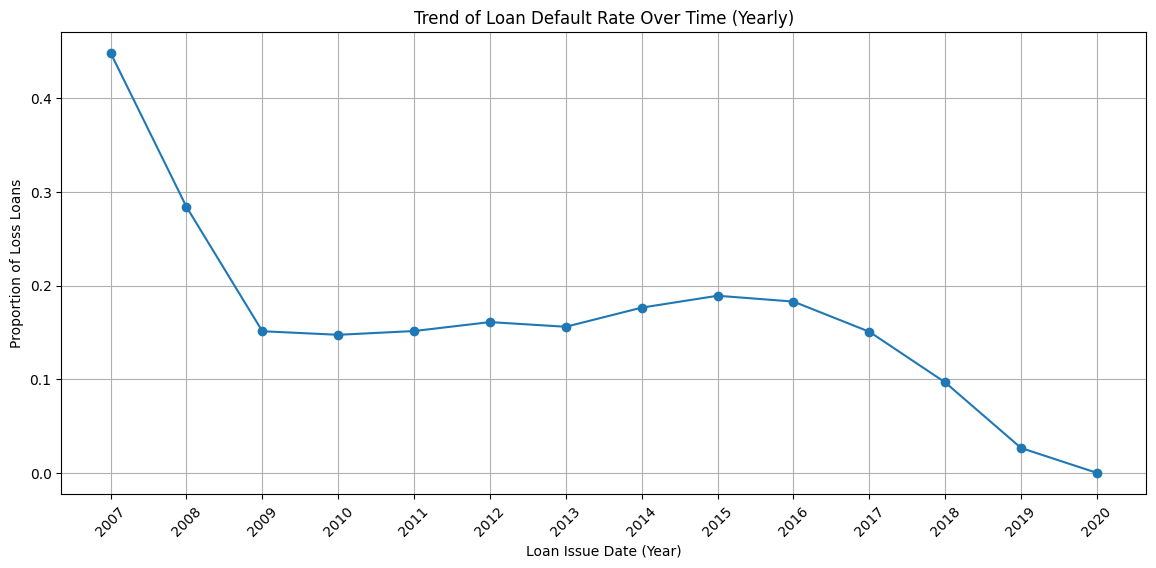

In [25]:
## convert issue_d
df_train_dropped['issue_d'].head()

df_train_dropped['issue_d'].isnull().sum()

df_train_dropped['loan_status'].unique()

# Convert issue_d to datetime
df_train_dropped['issue_d'] = pd.to_datetime(df_train_dropped['issue_d'], format='%b-%Y')
# Group by month-year and calculate the proportion of "loss" loans
loss_rate = df_train_dropped.groupby(df_train_dropped['issue_d'].dt.to_period('Y'))['loan_category'].apply(lambda x: (x == 'Loss').mean())

# Plot the trend
plt.figure(figsize=(14, 6))
#x_labels = loss_rate.index.astype(str)[::4]  # Show every 4th label
plt.plot(loss_rate.index.astype(str), loss_rate.values, marker='o', linestyle='-')
#plt.xticks(ticks=x_labels, rotation=45)
plt.xticks(rotation=45)
plt.xlabel("Loan Issue Date (Year)")
plt.ylabel("Proportion of Loss Loans")
plt.title("Trend of Loan Default Rate Over Time (Yearly)")
plt.grid(True)
plt.show()

In [26]:
# convert issue_d to an Ordinal Feature
df_train_dropped['issue_d_ordinal'] = df_train_dropped['issue_d'].dt.year - df_train_dropped['issue_d'].dt.year.min()
#df_train_dropped.drop(columns=['issue_d'], inplace=True)  # Drop original datetime column

df_train_dropped.drop(columns=["url"], inplace=True)
df_train_dropped["term"] = df_train_dropped["term"].str.extract("(\d+)").astype(float)
df_train_dropped["int_rate"] = df_train_dropped["int_rate"].replace("nan", np.nan)
df_train_dropped["int_rate"] = df_train_dropped["int_rate"].str.replace("%", "").astype(float) / 100

df_train_dropped = df_train_dropped.drop(["grade"], axis=1)

# Define base values for grades (lower = better credit, higher = higher risk)
grade_mapping = {"A" :1, "B" : 2, "C" : 3, "D" : 4, "E" : 5, "F" : 6, "G" : 7}

# Convert nan to np.nan
df_train_dropped["sub_grade"] = df_train_dropped["sub_grade"].replace("nan", np.nan)

# Check if has nan valus (1 nan)
df_train_dropped["sub_grade"].isna().sum()

df_train_dropped["sub_grade"] = df_train_dropped["sub_grade"].apply(lambda x: grade_mapping[str(x)[0]] * 10 + int(str(x)[1]) if pd.notna(x) else np.nan)


def convert_emp_length(emp):
    if pd.isna(emp):  # Handle missing values
        return np.nan
    if emp == "10+ years":
        return 10
    elif emp == "< 1 year":
        return 0
    else:
        return int(emp.split()[0])  # Extract the number from "X years"
## Check below for convertion criterion


## Convert emp_length to numeric
df_train_dropped["emp_length"] = df_train_dropped["emp_length"].apply(convert_emp_length)

In [27]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'purpose' column
df_train_dropped["purpose"] = le.fit_transform(df_train_dropped["purpose"])

# View unique mappings
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

# Convert 'title' from strings to numeric (Since similar to "Purpose, drop it")
num_unique_titles = df_train_dropped["title"].nunique()
title_counts = df_train_dropped["title"].value_counts()
purpose_counts = df_train_dropped["purpose"].value_counts()

df_train_dropped = df_train_dropped.drop(columns=["title"])

# Convert "zip_code" to numeric
df_train_dropped["zip_code"].unique()

# Drop zip_code
df_train_dropped = df_train_dropped.drop(columns=["zip_code"])

# Drop "addr_state"
df_train_dropped["addr_state"].unique()

# Map 'N' to 0 and 'Y' to 1
df_train_dropped["hardship_flag"] = df_train_dropped["hardship_flag"].map({
                                                                          "N": 0, "Y": 1})

df_train_dropped["hardship_flag"].unique()

# Map 'N' to 0 and 'Y' to 1
df_train_dropped["debt_settlement_flag"] = df_train_dropped["debt_settlement_flag"].map({
                                                                                        "N": 0, "Y": 1})
# Map 'Individual' to 0 and 'Joint App' to 1
df_train_dropped["application_type"] = df_train_dropped["application_type"].map(
    {"Individual": 0, "Joint App": 1})

df_train_dropped["last_credit_pull_d"] = pd.to_datetime(
    df_train_dropped["last_credit_pull_d"])

# Define reference date as the end of Q3 2020
reference_date = pd.to_datetime("2020-09-30")

df_train_dropped["last_credit_pull_d"] = (
    reference_date - df_train_dropped["last_credit_pull_d"]).dt.days

from datetime import datetime
df_train_dropped["earliest_cr_line"] = pd.to_datetime(df_train_dropped["earliest_cr_line"], format="%b-%Y")
df_train_dropped["earliest_cr_line"] = (
    (datetime.today().year - df_train_dropped["earliest_cr_line"].dt.year) * 12 +
    (datetime.today().month - df_train_dropped["earliest_cr_line"].dt.month)
)

df_train_dropped["revol_util"].unique()
df_train_dropped["revol_util"] = pd.to_numeric(df_train_dropped["revol_util"].str.rstrip("%"), errors="coerce") / 100
df_train_dropped["initial_list_status"] = df_train_dropped["initial_list_status"].map({"w": 0, "f": 1})
df_train_dropped["last_pymnt_d"] = pd.to_datetime(df_train_dropped["last_pymnt_d"], format="%b-%Y", errors="coerce")

{'car': 0, 'credit_card': 1, 'debt_consolidation': 2, 'educational': 3, 'home_improvement': 4, 'house': 5, 'major_purchase': 6, 'medical': 7, 'moving': 8, 'other': 9, 'renewable_energy': 10, 'small_business': 11, 'vacation': 12, 'wedding': 13}


<ipython-input-27-2efa57891b86>:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train_dropped["last_credit_pull_d"] = pd.to_datetime(


In [28]:
from datetime import datetime
df_train_dropped["months_since_last_pymnt"] = (
    (datetime.today().year - df_train_dropped["last_pymnt_d"].dt.year) * 12 +
    (datetime.today().month - df_train_dropped["last_pymnt_d"].dt.month)
)

In [ ]:
# Convert categorical features to category dtype for XGBoost
categorical_features = ["sub_grade", "term", "purpose"]
for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# One-Hot Encode "emp_length" since it has many categories
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_train = ohe.fit_transform(X_train[["emp_length"]])
encoded_val = ohe.transform(X_val[["emp_length"]])
encoded_test = ohe.transform(X_test[["emp_length"]])

# Convert encoded data to DataFrame
encoded_train_df = pd.DataFrame(encoded_train, index=X_train.index, columns=ohe.get_feature_names_out(["emp_length"]))
encoded_val_df = pd.DataFrame(encoded_val, index=X_val.index, columns=ohe.get_feature_names_out(["emp_length"]))
encoded_test_df = pd.DataFrame(encoded_test, index=X_test.index, columns=ohe.get_feature_names_out(["emp_length"]))

# Drop original "emp_length" and concatenate encoded features
X_train = X_train.drop(columns=["emp_length"]).reset_index(drop=True)
X_val = X_val.drop(columns=["emp_length"]).reset_index(drop=True)
X_test = X_test.drop(columns=["emp_length"]).reset_index(drop=True)

X_train = pd.concat([X_train, encoded_train_df], axis=1)
X_val = pd.concat([X_val, encoded_val_df], axis=1)
X_test = pd.concat([X_test, encoded_test_df], axis=1)

print("Categorical processing complete.")


In [52]:
import pickle
from sklearn.model_selection import train_test_split

# Step 1: Select exactly 60,000 rows from df_train_dropped
df_selected = df_train_dropped.sample(n=100000, random_state=42)  # Ensures reproducibility

# Step 2: Split selected data into train (60%), validation (20%), and test (20%)
df_train, df_temp = train_test_split(df_selected, test_size=0.40, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.50, random_state=42)

# Print dataset distribution
print(f"Training Set: {len(df_train)} rows ({len(df_train)/len(df_selected)*100:.1f}%)")
print(f"Validation Set: {len(df_val)} rows ({len(df_val)/len(df_selected)*100:.1f}%)")
print(f"Test Set: {len(df_test)} rows ({len(df_test)/len(df_selected)*100:.1f}%)")

Training Set: 60000 rows (60.0%)
Validation Set: 20000 rows (20.0%)
Test Set: 20000 rows (20.0%)


In [69]:
print(list(df_selected.columns))  # 直接打印完整的特征列表

['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'sub_grade', 'emp_title', 'emp_length', 'annual_inc', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq

In [57]:
print(f"df_train shape: {df_train.shape}")
print(f"df_selected shape: {df_selected.shape}")
print(f"df_train shape: {df_train.shape}")  # 应该是 (60000, N)
print(f"y_train shape: {df_train['loan_cat_numerical'].shape}")  # 应该是 (60000,)

# 确保 X_train 和 y_train 行数相同
X_train, y_train = df_train[selected_features], df_train["loan_cat_numerical"]
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # 应该相同

df_train shape: (60000, 115)
df_selected shape: (100000, 115)
df_train shape: (60000, 115)
y_train shape: (60000,)
X_train shape: (60000, 11), y_train shape: (60000,)


In [76]:
# Define features and target
# 在这里选择一系列features！！！

#selected_features = ["funded_amnt", "loan_amnt", "funded_amnt_inv", "term", "int_rate", "installment", "sub_grade", "emp_length", "annual_inc", "dti", "purpose"]
selected_features = [
    'loan_amnt',  # 贷款金额
    'funded_amnt',  # 实际获批的贷款金额
    'term',  # 贷款期限（如 36 个月 / 60 个月）
    'int_rate',  # 贷款利率
    'installment',  # 每期还款额
    'sub_grade',  # 贷款评级
    'annual_inc',  # 申请人的年收入
    'dti',  # 债务收入比
    'fico_range_low',  # 申请人的 FICO 信用评分（低端）
    'fico_range_high',  # 申请人的 FICO 信用评分（高端）
    'open_acc',  # 当前信用账户数量
    'revol_bal',  # 循环信用余额（信用卡等未偿还债务）
    'revol_util',  # 信用卡利用率
    'total_acc',  # 信用账户总数
    'mort_acc',  # 申请人是否有房贷账户
    'total_pymnt',  # 申请人已还的总金额
    'recoveries',  # 贷款回收金额（比如坏账追回的款项）
    'home_ownership_MORTGAGE',  # 住房情况（有房贷）
    'verification_status_Verified'  # 申请人是否经过收入验证
]

X_train, y_train = df_train[selected_features], df_train["loan_cat_numerical"]
X_val, y_val = df_val[selected_features], df_val["loan_cat_numerical"]
X_test, y_test = df_test[selected_features], df_test["loan_cat_numerical"]

In [ ]:
# Save datasets using pickle
# 刚刚没有读这个 长度是一样的
with open("train_val_test.pkl", "wb") as f:
    pickle.dump((X_train, X_val, X_test, y_train, y_val, y_test), f)

print("Data split and saved as 'train_val_test.pkl' for training in another notebook.")

In [71]:
print(len(X_train), len(y_train))  


60000 60000


In [31]:
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [60]:
# Load dataset
with open("/kaggle/input/loan-statustraining-data/train_val_test.pkl", "rb") as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

print("Data successfully loaded!")

Data successfully loaded!


In [61]:
print(len(X_train), len(y_train))  # These should be equal!


60000 60000


In [62]:
# Convert categorical features to category dtype for XGBoost
categorical_features = ["sub_grade", "purpose","term"]
for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")
    X_test[col] = X_test[col].astype("category")

print("Categorical processing complete.")

Categorical processing complete.


In [72]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",  # 适用于多分类任务
    enable_categorical=True,
    num_class=len(np.unique(y_train)),  # 目标变量类别数
    tree_method="hist",  # 更快的训练方式
    use_label_encoder=False,  # 关闭过时的 label encoding 警告
    eval_metric="mlogloss",  # 多分类损失函数
    early_stopping_rounds=10
)


In [73]:
print(f"X_train shape: {X_train.shape}")  # Should be (num_samples, num_features)
print(f"y_train shape: {y_train.shape}")  # Should be (num_samples,)


X_train shape: (60000, 20)
y_train shape: (60000,)


In [77]:
# 训练模型，使用早停防止过拟合
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # 验证集
    verbose=True  # 显示训练过程
)

[0]	validation_0-mlogloss:0.46793
[1]	validation_0-mlogloss:0.34373
[2]	validation_0-mlogloss:0.26728
[3]	validation_0-mlogloss:0.21727
[4]	validation_0-mlogloss:0.18393
[5]	validation_0-mlogloss:0.16052
[6]	validation_0-mlogloss:0.14393
[7]	validation_0-mlogloss:0.13193
[8]	validation_0-mlogloss:0.12325
[9]	validation_0-mlogloss:0.11742
[10]	validation_0-mlogloss:0.11242
[11]	validation_0-mlogloss:0.10969
[12]	validation_0-mlogloss:0.10702
[13]	validation_0-mlogloss:0.10437
[14]	validation_0-mlogloss:0.10158
[15]	validation_0-mlogloss:0.10013
[16]	validation_0-mlogloss:0.09960
[17]	validation_0-mlogloss:0.09771
[18]	validation_0-mlogloss:0.09667
[19]	validation_0-mlogloss:0.09478
[20]	validation_0-mlogloss:0.09311
[21]	validation_0-mlogloss:0.09201
[22]	validation_0-mlogloss:0.09068
[23]	validation_0-mlogloss:0.08988
[24]	validation_0-mlogloss:0.08918
[25]	validation_0-mlogloss:0.08903
[26]	validation_0-mlogloss:0.08802
[27]	validation_0-mlogloss:0.08735
[28]	validation_0-mlogloss:0.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=2, num_parallel_tree=None, ...)

In [84]:
# 预测测试集
y_pred = xgb_model.predict(X_val)
# 计算准确率
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.9790
Test Accuracy: 0.9807
